In [57]:
from elasticsearch import Elasticsearch
from elasticsearch.helpers import streaming_bulk
import glob
import ujson as json
from tqdm import tqdm
import os
import pandas as pd
from typing import Any, Dict, Iterable


In [260]:
additional_stopwords_list = ["działalność",
                             'produkcja',
                             'działalność',
                             'działalności',
                             "zakresie",
                             'i',
                             "związanych", "związany", "związane",
                             'z',
                             'sprzedaż',
                             'wyrobów',
                             'w',
                             'pozostałych',
                             'hurtowa',
                             'detaliczna',
                             'prowadzona',
                             'sklepach',
                             'oraz',
                             'wyspecjalizowanych',
                             'związana',
                             'gdzie',
                             'indziej',
                             'do',
                             'pozostała',
                             'wyłączeniem',
                             'usługowa',
                             'dla',
                             'zakresie',
                             'urządzeń', 'urządzenia',
                             'na',
                             'niesklasyfikowana',
                             'pozostałe',
                             'artykułów',
                             'wspomagająca', 'towarów']


money_regex = r'([0-9]+\s?[0-9]*\s?[0-9]*\s?(EUR|PLN){1})'
three_zeros_regex = r'([0-9]*\s?[0-9]*\s?(000)\s?)'
tys_regex = r'([0-9]+\s?(tys\.))(\s?(zł|EUR))'
mrgx1 = re.compile(money_regex)
mrgx2 = re.compile(tys_regex)


def str_replacer(x, repls):
    for repl in repls:
        x = x.replace(repl, "")
    return x


def extract_fund_size(description):
    """Extract minimum and maximum funds"""
    m1 = mrgx1.findall(description)
    m2 = mrgx2.findall(description)
    if m2 or m1:
        if m2:  # m2 goes first
            replaces = ('tys.', 'PLN', "zł", " ")
            ms = set([m[0] for m in m2])
            ms_ = [int(str_replacer(m.strip(), replaces))*1000 for m in ms]
            return min(ms_), max(ms_)
        if m1:
            ms = set([m[0] for m in m1])
            replaces = ('EURO', "EUR", "PLN", " ")
            ms_ = [int(str_replacer(m.strip(), replaces)) for m in ms]
            return min(ms_), max(ms_)
    return None, None


def create_fund_indx(es: Elasticsearch, index: str):
    dense_funds = {
        "settings": {
            "analysis": {
                "analyzer": {
                    "pl_analyzer": {
                        "type": "custom",
                        "tokenizer": "whitespace",
                        "filter": ["lowercase", "polish_stop_filter",
                                   "polish_stem", "polish_stop_filter"],
                        "char_filter": ["html_strip"]
                    },
                },
                "filter": {
                    "polish_stop_filter": {
                        "type": "stop",
                        "ignore_case": True,
                        # plugin required
                        "stopwords": ["_polish_", *additional_stopwords_list]
                    }
                }
            },
        },
        "mappings": {
            "properties": {
                # "text_vector": {
                #     "type": "dense_vector",
                #     "dims": doc_dims
                # },
                "description": {
                    "type": "text",
                    "analyzer": "pl_analyzer"
                },
                "name": {
                    "type": "text"
                },
                "url": {
                    "type": "text"
                },
                "fund_range": {
                    "type": "text"  # str
                },
                "PKD": {
                    "type": "text"  # List[str]
                },
                "enterprise_size": {
                    "type": "text"  # List[str]
                },
                "financing_type": {
                    "type": "text"  # idk
                },
                "files": {
                    "type": "text"
                }
            }
        }
    }
    es.indices.delete(index, ignore=[400, 404])
    es.indices.create(index=index, body=dense_funds)


def strip_extra_tags(txt):
    for tag in (u'<em>', u'</em>'):
        txt = txt.replace(tag, "")
    for tag in ('\n', '\t', u'\xa0'):
        txt = txt.replace(tag, u' ', )
    return txt


def stream_fund_docs(src: str, src_df: pd.DataFrame, index: str) -> Iterable[Dict[str, Any]]:
    """Stream funds to the ES stack"""
    records = src_df.to_dict('records')
    counter = 0
    for record in records:
        stripped_desc = strip_extra_tags(record['FullDesc'])
        min_funds, max_funds = extract_fund_size(stripped_desc)
        doc = {
            "_index": index,
            "_source": {
                'description': stripped_desc,
                'name': record['Name'],
                'URL': record['URL'],
                'fund_source': src
            }
        }
        if min_funds is not None and min_funds > 1000:
            counter += 1
            doc["fund_range"] = min_funds if min_funds == max_funds else f'{min_funds}-{max_funds}'
        yield doc
    print("FOUND extracted funds", counter)


def upload_datasets(es: Elasticsearch, indx_name='funds', dataset_ext="*.pkl"):
    """Uploads all datasets to ES"""
    create_fund_indx(es, index=indx_name)
    for src_itm in glob.glob(os.path.join(os.pardir, 'backend', 'data', dataset_ext)):
        df = pd.read_pickle(src_itm)
        print(src_itm, df.columns)
        bsn = os.path.basename(src_itm).replace(".pkl", "").upper()
        stream = stream_fund_docs(src=bsn, src_df=df, index=indx_name)
        for ok, response in streaming_bulk(es, actions=stream):
            if not ok:
                print(response)


In [261]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

user = os.environ.get("USER")
password = os.environ.get("PASS")
addr = os.environ.get("ADDR")

src_df = pd.read_pickle('../backend/data/PFR.pkl')
es = Elasticsearch(
    hosts=[
        f"http://{user}:{password}@{addr}:9200"
    ]

)
upload_datasets(es, indx_name="funds")
# create_fund_indx(es)
# stream = stream_fund_docs(src_df=src_df)
# for ok, response in streaming_bulk(es, actions=stream):
#     if not ok:
#         print(response)


/opt/homebrew/lib/python3.9/site-packages/elasticsearch/connection/base.py:208: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.13/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


../backend/data/PFR.pkl Index(['Name', 'FullDesc', 'URL'], dtype='object')
FOUND extracted funds 11


/opt/homebrew/lib/python3.9/site-packages/elasticsearch/connection/base.py:208: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.13/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
/opt/homebrew/lib/python3.9/site-packages/elasticsearch/connection/base.py:208: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.13/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
/opt/homebrew/lib/python3.9/site-packages/elasticsearch/connection/base.py:208: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be 

../backend/data/EURO.pkl Index(['Name', 'FullDesc', 'URL'], dtype='object')
FOUND extracted funds 0
../backend/data/NCBR.pkl Index(['Name', 'FullDesc', 'URL'], dtype='object')
FOUND extracted funds 0
../backend/data/BGK.pkl Index(['Name', 'FullDesc', 'URL'], dtype='object')
FOUND extracted funds 37


/opt/homebrew/lib/python3.9/site-packages/elasticsearch/connection/base.py:208: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.13/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


../backend/data/PARP.pkl Index(['FullDesc', 'Name', 'URL'], dtype='object')
FOUND extracted funds 21


/opt/homebrew/lib/python3.9/site-packages/elasticsearch/connection/base.py:208: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.13/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


In [258]:
# from elasticsearch.client import IndicesClient

# indices_client = IndicesClient(es)
# indices_client.analyze(
#     index='test',
#     body={
#         "analyzer": "pl_analyzer",
#         "text": "PRZETWARZANIE DANYCH; ZARZĄDZANIE STRONAMI INTERNETOWYMI (HOSTING) I PODOBNA DZIAŁALNOŚĆ"
#     }
# )


In [259]:
from typing import List


def simple_query(PKD: str):
    query = {
        'query': {
            'simple_query_string': {
                'query': PKD,
                "fields": ["description"]
            }
        },
        "highlight": {
            "fields": {
                "description": {}  # highlight here
            }
        }
    }

    results = es.search(index='funds', body=query)
    return results['hits']['hits']


def multiple_term_search(PKD: List[str]):
    query = {
        'query': {
            'query_string': {
                'query': " OR ".join([f"({q})" for q in PKD]),
                "fields": ["description"]
            }
        },
        "highlight": {
            "fields": {
                "description": {}  # highlight here
            }
        }
    }

    results = es.search(index='funds', body=query)
    # return results['hits']['hits']
    return [{
        "highlight": r['highlight'],
        "data": {
            k: v for k, v in r['_source'].items() if k != 'description'
        }
    } for r in results['hits']['hits']]


def es_search(PKD: str):
    query = {
        'query': {
            "bool": {
                "must": {
                    "query_string": {
                        "query": PKD
                    }
                },
                # "should": [
                #     {"term": {"tags": "lat"}}
                # ],
                # "minimum_should_match": 1
            },
        },
        "highlight": {
            "fields": {
                "description": {},
                "type": "unified"
            }
        }
    }
    results = es.search(index='funds', body=query)
    return [r['highlight'] for r in results['hits']['hits']]


# simple_query("działalność związana z wytwarzaniem oprogramowania")
multiple_term_search([
    "DZIAŁALNOŚĆ ZWIĄZANA Z OPROGRAMOWANIEM",
    "DZIAŁALNOŚĆ WYDAWNICZA W ZAKRESIE POZOSTAŁEGO OPROGRAMOWANIA",
    "DZIAŁALNOŚĆ ZWIĄZANA Z DORADZTWEM W ZAKRESIE INFORMATYKI",
    "DZIAŁALNOŚĆ ZWIĄZANA Z ZARZĄDZANIEM URZĄDZENIAMI INFORMATYCZNYMI",
    "POZOSTAŁA DZIAŁALNOŚĆ USŁUGOWA W ZAKRESIE TECHNOLOGII INFORMATYCZNYCH I KOMPUTEROWYCH",
    "PRZETWARZANIE DANYCH; ZARZĄDZANIE STRONAMI INTERNETOWYMI (HOSTING) I PODOBNA DZIAŁALNOŚĆ",
    "DZIAŁALNOŚĆ RACHUNKOWO-KSIĘGOWA; DORADZTWO PODATKOWE",
    "POZOSTAŁE DORADZTWO W ZAKRESIE PROWADZENIA DZIAŁALNOŚCI GOSPODARCZEJ I ZARZĄDZANIA",
    "POZOSTAŁE BADANIA I ANALIZY TECHNICZNE",
    "BADANIA NAUKOWE I PRACE ROZWOJOWE W DZIEDZINIE POZOSTAŁYCH NAUK PRZYRODNICZYCH I TECHNICZNYCH"
])


[{'highlight': {'description': ['IT (PKD J.62 -Działalność związana z <em>oprogramowaniem</em> i <em>doradztwem</em> w zakresie <em>informatyki</em> oraz działalność',
    '<em>prac</em> badawczo-rozwojowych we współpracy z innymi podmiotami i placówkami <em>naukowymi</em> Wdrażanie w przedsiębiorstwie',
    'zdalnej usługi <em>rozwojowej</em> <em>Zarządzanie</em> projektem <em>rozwojowym</em> <em>Zarządzanie</em> sprzedażą usług <em>rozwojowych</em> Diagnozowanie',
    'mediacji sądowych i pozasądowych w sprawach <em>gospodarczych</em> Studia podyplomowe – systemy <em>zarządzania</em> klasy',
    'Zasady dotyczące rekrutacji znajdziesz na <em>stronach</em> <em>internetowych</em> Operatorów.']},
  'data': {'name': 'Kompetencje dla sektorów 2 - oferta dla przedsiębiorców',
   'URL': 'https://www.parp.gov.pl/component/grants/grants/kompetencje-dla-sektorow-2',
   'fund_source': 'PARP'}},
 {'highlight': {'description': ['IT (PKD J.62 -Działalność związana z <em>oprogramowaniem</em> i <em>

In [18]:
import pandas as pd


# df = pd.read_csv('../BKG/bgk.tsv', sep='\t')
# df.to_pickle('../backend/data/BGK.pkl')
df = pd.read_csv('../PFR/pfr.tsv', sep='\t')
df.rename(columns={
    "name": "Name",
    "text": "FullDesc",
    "url": "URL"
}, inplace=True
)
df.to_pickle('../backend/data/PFR.pkl')
# df.to_pickle('../backend/data/BGK.pkl')


In [83]:
x = 'alności</em> gospodarczej oraz przedsiębiorcy prowadzących <em>działalność</em> gospodarczą'
x.replace(u"<em>", "")


'alności</em> gospodarczej oraz przedsiębiorcy prowadzących działalność</em> gospodarczą'

In [27]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

user = os.environ.get("USER")
password = os.environ.get("PASS")
addr = os.environ.get("ADDR")

# src_df = pd.read_pickle('../pfr/PFR_free_txt.pkl')
es = Elasticsearch(
    hosts=[
        f"http://{user}:{password}@{addr}:9200"
    ]
)


def simple_query(PKD: str):
    query = {
        'query': {
            'simple_query_string': {
                'query': PKD,
                "fields": ["description"]
            }
        },
        "highlight": {
            "fields": {
                "description": {}  # highlight here
            }
        }
    }

    results = es.search(index='funds', body=query)
    return results['hits']['hits']


# simple_query(
#     "inclusion"
# )


/opt/homebrew/lib/python3.9/site-packages/elasticsearch/connection/base.py:208: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.13/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


[]

In [94]:
import pickle
from nltk import word_tokenize
from collections import Counter
pkd = pickle.load(open("../backend/pkds.pkl", "rb"))

words = Counter()

for (pkd, desc, _) in pkd:
    base = pkd.split("-")[-1].strip().lower()
    for token in word_tokenize(base):
        words[token] += 1


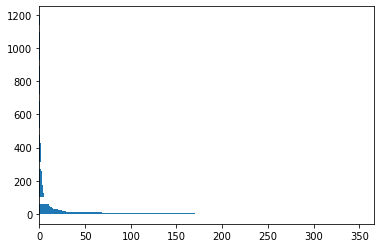

In [102]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
words_ = [w[0] for w in words.most_common()]
occs_ = [w[1] for w in words.most_common()]
inds = np.arange(
    len(words_)
)
barh = ax.barh(
    inds, occs_
)
# ax.set_yticks(inds, labels=words)
# ax.bar_label(words_)


In [325]:
import pickle
import re


def str_replacer(x, repls):
    for repl in repls:
        x = x.replace(repl, "")
    return x


example_data = pickle.load(open('../backend/data/BGK.pkl', 'rb'))
company_regex = r'(MŚP|mikro-|)''
money_regex = r'([0-9]+\s?[0-9]*\s?[0-9]*\s?(EUR|PLN){1})'
three_zeros_regex = r'([0-9]*\s?[0-9]*\s?(000)\s?)'
tys_regex = r'([0-9]+\s?(tys\.))(\s?(zł|EUR))'
mrgx1 = re.compile(money_regex)
mrgx2 = re.compile(tys_regex)
c = 0
for name, desc in zip(
        example_data['Name'],
        example_data['FullDesc']):

    m1 = mrgx1.findall(desc)
    m2 = mrgx2.findall(desc)
    if m2 or m1:
        if m1:
            ms = set([m[0] for m in m1])
            replaces = ('EURO', "EUR", "PLN", " ")
            ms_ = [int(str_replacer(m.strip(), replaces)) for m in ms]
        else:
            replaces = ('tys.', 'PLN', "zł", " ")
            ms = set([m[0] for m in m2])
            ms_ = [int(str_replacer(m.strip(), replaces))*1000 for m in ms]
        c += 1

print(c)


SyntaxError: invalid syntax (2458105017.py, line 12)

In [327]:
import pickle
import string
import random


def create_company_indx(es: Elasticsearch, dims: int, index: str = "company"):
    dense_funds = {
        "mappings": {
            "properties": {
                "pkd_vector": {
                    "type": "dense_vector",
                    "dims": dims
                },
                "pkd": {
                    "type": "text"
                },
                "name": {
                    "type": "text"
                },
                "nip": {
                    "type": "text"  # str
                },
                "regon": {
                    "type": "text"  # List[str]
                },
                "entity_type": {
                    "type": "text"
                }
            }
        }
    }
    es.indices.delete(index, ignore=[400, 404])
    es.indices.create(index=index, body=dense_funds)


def dense_query(es: Elasticsearch, query_vector: List[int]):
    query = {
        "query": {
            "script_score": {
                "query": {
                    "match_all": {}
                },
                "script": {
                    "source": "dotProduct(params.queryVector, doc['pkd_vector']);",
                    "params": {
                        "queryVector": query_vector
                    }
                }
            }
        }
    }
    print(query)
    results = es.search(
        index="company",
        body=query
    )
    return results["hits"]["hits"]


def add_company_to_index(es: Elasticsearch, company_dict: Dict[str, Any]):
    pkds = company_dict['pkd']
    pkd_vector = create_binary_pkd_vector(pkds)
    doc = {
        "pkd_vector": [random.randint(0, 1) for i in range(len(pkd_vector_decoder))],
        "nip": company_dict['nip'],
        'regon': company_dict['regon'],
        'name': company_dict['name'],
        'entity_type': company_dict["type_of_entity"],
        "pkd": company_dict['pkd']
    }
    nip = company_dict['nip']
    print(nip, type(nip))
    es.update(index="company", doc_type="_doc",
              id=nip,
              body={
                  "doc": doc,
                  'doc_as_upsert': True
              })


pkd_vector_decoder = {}
pkd_data = pickle.load(open('../backend/pkds.pkl', 'rb'))
table = str.maketrans(dict.fromkeys(string.punctuation))
for (pkd_prim, _, _) in pkd_data:
    key = pkd_prim.split("-")[-1].strip().lower()
    key = key.translate(table)
    pkd_vector_decoder[key] = len(pkd_vector_decoder)
json.dump(pkd_vector_decoder, open('pkd_vector_decoder.json', 'w'))

create_company_indx(es, dims=len(pkd_vector_decoder))
for i in range(10):
    add_company_to_index(es, company_dict={
        "nip": "".join([str(0) for i in range(10)]),
        "regon": "".join([str(random.randint(1, 10)) for i in range(10)]),
        "name": "test",
        "type_of_entity": "test",
        "pkd":  [
                "DZIAŁALNOŚĆ ZWIĄZANA Z OPROGRAMOWANIEM",
                "DZIAŁALNOŚĆ WYDAWNICZA W ZAKRESIE POZOSTAŁEGO OPROGRAMOWANIA",
                "DZIAŁALNOŚĆ ZWIĄZANA Z DORADZTWEM W ZAKRESIE INFORMATYKI",
                "DZIAŁALNOŚĆ ZWIĄZANA Z ZARZĄDZANIEM URZĄDZENIAMI INFORMATYCZNYMI",
                "POZOSTAŁA DZIAŁALNOŚĆ USŁUGOWA W ZAKRESIE TECHNOLOGII INFORMATYCZNYCH I KOMPUTEROWYCH",
                "PRZETWARZANIE DANYCH; ZARZĄDZANIE STRONAMI INTERNETOWYMI (HOSTING) I PODOBNA DZIAŁALNOŚĆ",
                "DZIAŁALNOŚĆ RACHUNKOWO-KSIĘGOWA; DORADZTWO PODATKOWE",
                "POZOSTAŁE DORADZTWO W ZAKRESIE PROWADZENIA DZIAŁALNOŚCI GOSPODARCZEJ I ZARZĄDZANIA",
                "POZOSTAŁE BADANIA I ANALIZY TECHNICZNE",
                "BADANIA NAUKOWE I PRACE ROZWOJOWE W DZIEDZINIE POZOSTAŁYCH NAUK PRZYRODNICZYCH I TECHNICZNYCH"
        ]
    })
dense_query(
    es, v


)


failed: DZIAŁALNOŚĆ RACHUNKOWO-KSIĘGOWA; DORADZTWO PODATKOWE
0000000000 <class 'str'>
failed: DZIAŁALNOŚĆ RACHUNKOWO-KSIĘGOWA; DORADZTWO PODATKOWE
0000000000 <class 'str'>
failed: DZIAŁALNOŚĆ RACHUNKOWO-KSIĘGOWA; DORADZTWO PODATKOWE
0000000000 <class 'str'>
failed: DZIAŁALNOŚĆ RACHUNKOWO-KSIĘGOWA; DORADZTWO PODATKOWE
0000000000 <class 'str'>
failed: DZIAŁALNOŚĆ RACHUNKOWO-KSIĘGOWA; DORADZTWO PODATKOWE
0000000000 <class 'str'>
failed: DZIAŁALNOŚĆ RACHUNKOWO-KSIĘGOWA; DORADZTWO PODATKOWE
0000000000 <class 'str'>
failed: DZIAŁALNOŚĆ RACHUNKOWO-KSIĘGOWA; DORADZTWO PODATKOWE
0000000000 <class 'str'>
failed: DZIAŁALNOŚĆ RACHUNKOWO-KSIĘGOWA; DORADZTWO PODATKOWE
0000000000 <class 'str'>
failed: DZIAŁALNOŚĆ RACHUNKOWO-KSIĘGOWA; DORADZTWO PODATKOWE
0000000000 <class 'str'>
failed: DZIAŁALNOŚĆ RACHUNKOWO-KSIĘGOWA; DORADZTWO PODATKOWE
0000000000 <class 'str'>
{'query': {'script_score': {'query': {'match_all': {}}, 'script': {'source': "dotProduct(params.queryVector, doc['pkd_vector']);", 'params':

[]

In [319]:
def create_binary_pkd_vector(pkds):
    vector = np.zeros((len(pkd_vector_decoder)), dtype=float)
    for pkd in pkds:
        key = pkd.strip().lower()
        key = key.translate(table)
        if key in pkd_vector_decoder:
            indx = pkd_vector_decoder[key]
            vector[indx] = 1
        else:
            print(f"failed: {pkd}")
    return vector.tolist()


v = create_binary_pkd_vector(
    [
        "DZIAŁALNOŚĆ ZWIĄZANA Z OPROGRAMOWANIEM",
        "DZIAŁALNOŚĆ WYDAWNICZA W ZAKRESIE POZOSTAŁEGO OPROGRAMOWANIA",
        "DZIAŁALNOŚĆ ZWIĄZANA Z DORADZTWEM W ZAKRESIE INFORMATYKI",
        "DZIAŁALNOŚĆ ZWIĄZANA Z ZARZĄDZANIEM URZĄDZENIAMI INFORMATYCZNYMI",
        "POZOSTAŁA DZIAŁALNOŚĆ USŁUGOWA W ZAKRESIE TECHNOLOGII INFORMATYCZNYCH I KOMPUTEROWYCH",
        "PRZETWARZANIE DANYCH; ZARZĄDZANIE STRONAMI INTERNETOWYMI (HOSTING) I PODOBNA DZIAŁALNOŚĆ",
        "DZIAŁALNOŚĆ RACHUNKOWO-KSIĘGOWA; DORADZTWO PODATKOWE",
        "POZOSTAŁE DORADZTWO W ZAKRESIE PROWADZENIA DZIAŁALNOŚCI GOSPODARCZEJ I ZARZĄDZANIA",
        "POZOSTAŁE BADANIA I ANALIZY TECHNICZNE",
        "BADANIA NAUKOWE I PRACE ROZWOJOWE W DZIEDZINIE POZOSTAŁYCH NAUK PRZYRODNICZYCH I TECHNICZNYCH"
    ]
)
print(sum(v))


failed: DZIAŁALNOŚĆ RACHUNKOWO-KSIĘGOWA; DORADZTWO PODATKOWE
9.0


In [328]:
create_company_indx(es, dims=len(pkd_vector_decoder))

/opt/homebrew/lib/python3.9/site-packages/elasticsearch/connection/base.py:208: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.13/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
